In [2]:
#import libraries and modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#set option for display all the rows and all the columns
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.set_option('display.max_colwidth', None)


In [4]:
#get glossary
# glossary = pd.read_csv('https://raw.githubusercontent.com/davidgutkovsky/hockey-repo/main/goalie_clutch/MoneyPuck_Shot_Data_Dictionary.csv')
# glossary

In [5]:
data = pd.read_csv('https://raw.githubusercontent.com/davidgutkovsky/hockey-repo/main/goalie_clutch/shots_2021.csv')

In [6]:
#create team --> division mapping
divs = {
        'Atlantic'    : ['TBL','TOR','BUF','BOS','OTT','FLA','DET','MTL'],
        'Metropolitan': ['WSH','CAR','CBJ','NJD','PHI','PIT','NYI','NYR'],
        'Central'     : ['NSH','STL','COL','MIN','WPG','DAT','CHI','ARI'],
        'Pacific'     : ['VGK','ANA','LAK','CGY','SJS','EDM','VAN','SEA']
       }

for d in list(divs.keys()):
    teams = divs[d]
    div   = [d] * len(teams)
    
    if list(divs.keys()).index(d) == 0:
        d   = {'goalieTeamCode': teams, 'division': div}
        dff = pd.DataFrame(data=d)
    else:
        d  = {'goalieTeamCode': teams, 'division': div}
        df = pd.DataFrame(data=d)
        dff = dff.append(df)
        

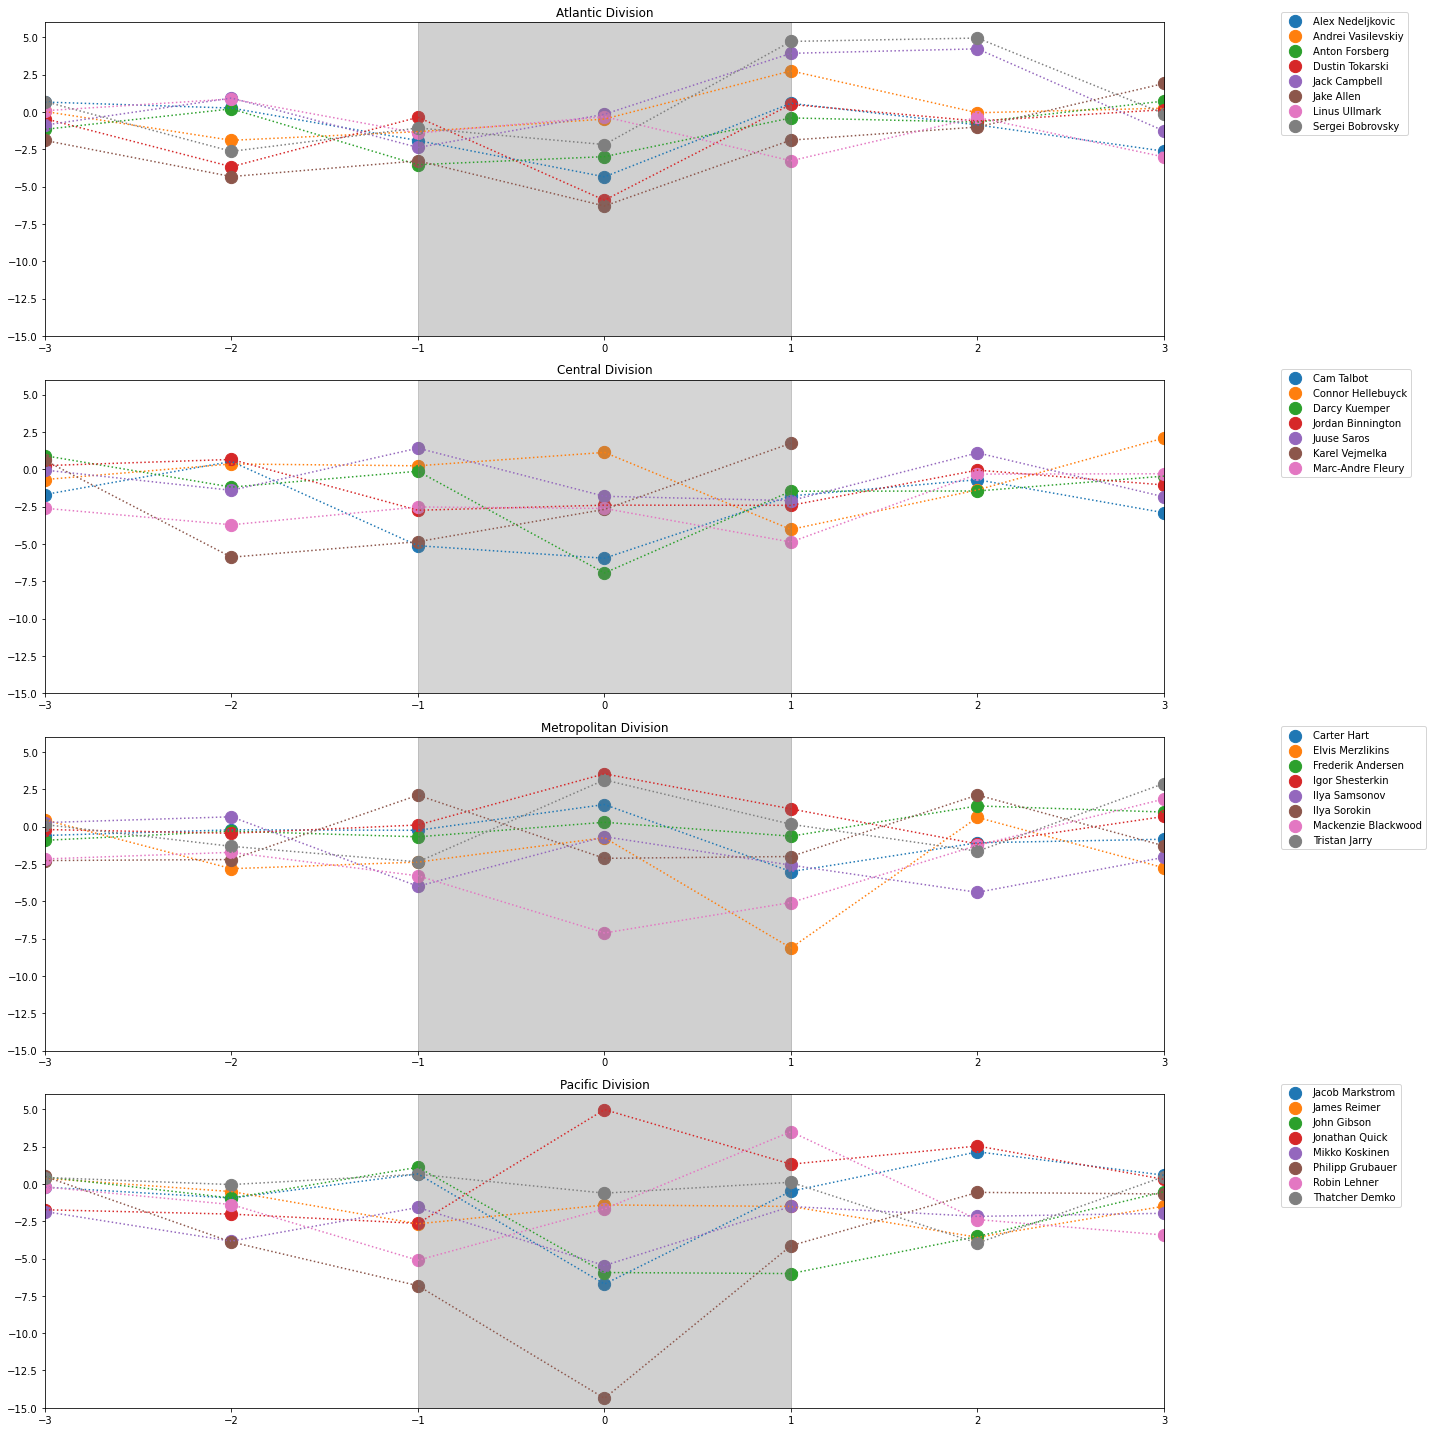

In [7]:
GOAL_BOUND = 3

clutch                     = data.copy()
clutch['isGoalieHome']     = np.where(clutch['isHomeTeam'] == 1,-1,1)
clutch['goalieTeamCode']   = np.where(clutch['isHomeTeam'] == 1,clutch['awayTeamCode'],clutch['homeTeamCode'])

#get the goalie with the highest shot total faced by team
goalies_list = (
                clutch[
                         (clutch['goalieNameForShot'].notnull())
                       & (clutch['event'].isin(['SHOT','GOAL'])) 
                      ]
                    .groupby(['goalieIdForShot','goalieTeamCode'])
                    .agg(shots = ('shotID','count'))
               )
goalies_list['rank'] = goalies_list.groupby('goalieTeamCode')['shots'].rank(method = 'first', ascending = False)
first_goalies_list = goalies_list[goalies_list['rank'] == 1].reset_index()[['goalieIdForShot']]

clutch = clutch.merge(dff,how = 'inner', on = 'goalieTeamCode')


clutch['differenceGoals']  = clutch['homeTeamGoals'] - clutch['awayTeamGoals']
clutch['differenceGoalie'] = clutch['differenceGoals'] * clutch['isGoalieHome']
clutch['is_shot'] = np.where(clutch['event'] == 'SHOT',1,0)
clutch_shots = clutch[
                        (clutch['event'].isin(['GOAL','SHOT']))
                      & (clutch['differenceGoalie'].between(-GOAL_BOUND,GOAL_BOUND))  
                   ]

#Summary for each goalie: saves, goals allowed, expected goals
goalies_table = (
                 clutch_shots
                    .merge(first_goalies_list,how = 'inner', on = 'goalieIdForShot')
                    .groupby(['goalieNameForShot','division','differenceGoalie'])
                    .agg(saves  = ('is_shot','sum'), 
                         goals  = ('goal','sum'), 
                         xgoals = ('xGoal','sum'))
                    .reset_index()
                )

goalies_table['save_percentage'] = goalies_table['saves']/(goalies_table['saves'] + goalies_table['goals'])
goalies_table['save_goals']      = goalies_table['xgoals'] - goalies_table['goals']

division_list = goalies_table['division'].unique().tolist()
fig, ax = plt.subplots(len(division_list), figsize = (20,20))

for d in division_list:
    table = goalies_table[goalies_table['division'] == d]
    i = 0
    for g in table['goalieNameForShot'].unique(): 
        yo = goalies_table[goalies_table['goalieNameForShot'] == g]
        ax[division_list.index(d)].scatter(yo['differenceGoalie'], yo['save_goals'], s = 150, label = g)
        ax[division_list.index(d)].legend(bbox_to_anchor=(1.1, 1.05))
        ax[division_list.index(d)].plot(yo['differenceGoalie'], yo['save_goals'], ':')
        ax[division_list.index(d)].axvspan(-1, 1, alpha=0.05, color='grey', label = 'Clutch Moments'*i)
        ax[division_list.index(d)].set_title(f'{d} Division')
        ax[division_list.index(d)].set(xlim=(-GOAL_BOUND, GOAL_BOUND), ylim=(-15, 6))
plt.tight_layout()
plt.savefig('clutch_goalies_all')


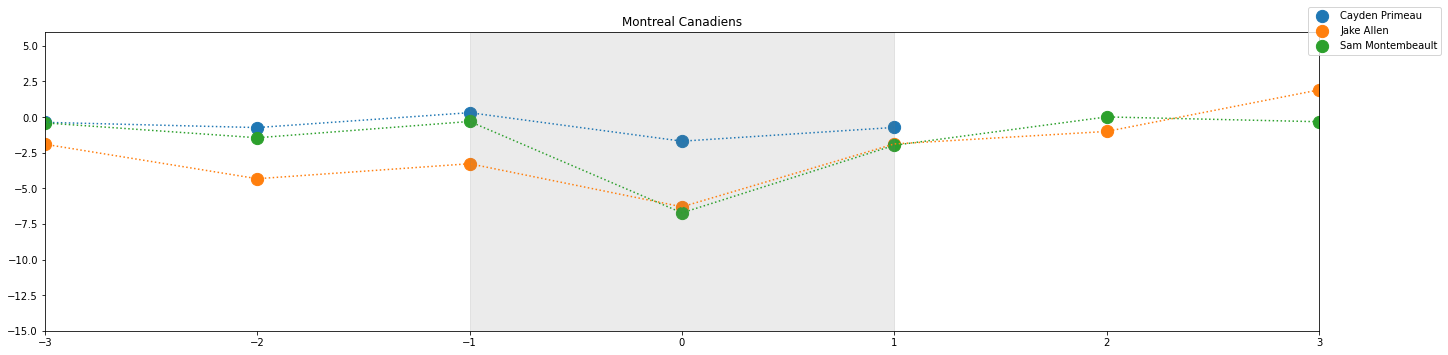

In [8]:
#Montreal Goaltenders
goalies_table = (
                 clutch_shots[clutch_shots['goalieTeamCode'] == 'MTL']
                    .groupby(['goalieNameForShot','differenceGoalie'])
                    .agg(saves  = ('is_shot','sum'), 
                         goals  = ('goal','sum'), 
                         xgoals = ('xGoal','sum'))
                    .reset_index()
                )

goalies_table['save_percentage'] = goalies_table['saves']/(goalies_table['saves'] + goalies_table['goals'])
goalies_table['save_goals']      = goalies_table['xgoals'] - goalies_table['goals']

fig, ax = plt.subplots(figsize = (20,5))

for g in goalies_table['goalieNameForShot'].unique().tolist(): 
        yo = goalies_table[goalies_table['goalieNameForShot'] == g]
        ax.scatter(yo['differenceGoalie'], yo['save_goals'], s = 150, label = g)
        ax.legend(bbox_to_anchor=(1.1, 1.1))
        ax.plot(yo['differenceGoalie'], yo['save_goals'], ':')
        ax.axvspan(-1, 1, alpha=0.05, color='grey', label = 'Clutch Moments'*i)
        ax.set_title('Montreal Canadiens')
        ax.set(xlim=(-GOAL_BOUND, GOAL_BOUND), ylim=(-15, 6))
plt.tight_layout()
plt.savefig('clutch_goalies_mtl')